#### Let's import everything we need

In [165]:
import requests
import pandas as pd
import tweepy
from tweepy import TweepError
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [166]:
url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url, allow_redirects=True)
open('image-predictions.tsv', 'wb').write(r.content)


335079

#### Loading the Data

In [167]:
df_image_preds = pd.read_csv('image-predictions.tsv',delimiter='\t',encoding='utf-8')
df_image_preds_original = df_image_preds.copy
df_image_preds.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [168]:
df_twitter = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_enhanced_original = df_twitter.copy()
df_twitter.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Collecting twitter data using Tweepy
Now, let's setup the twitter code, to allow us to retrieve more data about the tweets. 

In [169]:
# Fill the X's with the credentials obtained by  
# following the above mentioned procedure. 
consumer_key = "" 
consumer_secret = ""
access_key = ""
access_secret = ""
  
# Function to extract tweets 
def get_tweet_data(id_of_tweet): 
          
        # Authorization to consumer key and consumer secret 
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
  
        # Access to user's access key and access secret 
        auth.set_access_token(access_key, access_secret) 
  
        # Calling api 
        api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True) 
  
        tweet = api.get_status(id_of_tweet)
        return tweet.text, tweet.favorite_count, tweet.retweet_count, tweet._json
        
  
# Testing the function  
# get_tweet_data("666020888022790149")

Let's move to creating a fresh dataframe from collected data.
Now, this is where I noticed issue number 1. Some of the twitter ids are invalid.

> This is the code used to generate the tweet_json.txt. But, it is commented out to allow the entire notebook to be executed easily, without having to wait 30 mins everytime.

In [170]:
df = df_twitter.copy()
"""
invalid_ids = []

twitter_json_dict = []

for value in df.itertuples():
    try: 
        text, fav_count, retweet_count, full_json = get_tweet_data(value.tweet_id)
        
        json_dict = {
            'tweet_id':value.tweet_id,
            'tweet_fav_count':fav_count,
            'tweet_retweet_count':retweet_count,
            'tweet_full_json':full_json,
        }
        twitter_json_dict.append(json_dict)
        
        if value.Index % 200 == 0:
            print(value.Index, "of", len(df))
            
    except TweepError as te:
        invalid_ids.append(value)

df_twitter_json = pd.DataFrame(twitter_json_dict)
df_twitter_json.to_csv('tweet_json.txt') 
df_twitter_json.head()
"""

'\ninvalid_ids = []\n\ntwitter_json_dict = []\n\nfor value in df.itertuples():\n    try: \n        text, fav_count, retweet_count, full_json = get_tweet_data(value.tweet_id)\n        \n        json_dict = {\n            \'tweet_id\':value.tweet_id,\n            \'tweet_fav_count\':fav_count,\n            \'tweet_retweet_count\':retweet_count,\n            \'tweet_full_json\':full_json,\n        }\n        twitter_json_dict.append(json_dict)\n        \n        if value.Index % 200 == 0:\n            print(value.Index, "of", len(df))\n            \n    except TweepError as te:\n        invalid_ids.append(value)\n\ndf_twitter_json = pd.DataFrame(twitter_json_dict)\ndf_twitter_json.to_csv(\'tweet_json.txt\') \ndf_twitter_json.head()\n'

### Loading twitter data back from created json

In [171]:
df_twitter = pd.read_csv('tweet_json.txt')
df_twitter_original = df_twitter.copy()
df_twitter.head()

,Unnamed: 0,tweet_fav_count,tweet_full_json,tweet_id,tweet_retweet_count
0,0,37165,{'created_at': 'Tue Aug 01 16:23:56 +0000 2017...,892420643555336193,7950
1,1,31966,{'created_at': 'Tue Aug 01 00:17:27 +0000 2017...,892177421306343426,5905
2,2,24071,{'created_at': 'Mon Jul 31 00:18:03 +0000 2017...,891815181378084864,3904
3,3,40488,{'created_at': 'Sun Jul 30 15:58:51 +0000 2017...,891689557279858688,8105
4,4,38711,{'created_at': 'Sat Jul 29 16:00:24 +0000 2017...,891327558926688256,8787


### Combining all of the data
Before trying to find and solve all of the issues in the data I thought, it might be easier to combine all of the data together first and then do the wrangling, so here we go.

In [172]:
df_image_preds.head()
df_twitter.head()
df_outer = pd.merge(df_twitter, df_image_preds, on='tweet_id', how='outer')
df_outer = pd.merge(df_outer, df, on='tweet_id', how='outer')
df_outer.info()
df_outer.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 32 columns):
Unnamed: 0                    2333 non-null float64
tweet_fav_count               2333 non-null float64
tweet_full_json               2333 non-null object
tweet_id                      2356 non-null int64
tweet_retweet_count           2333 non-null float64
jpg_url                       2075 non-null object
img_num                       2075 non-null float64
p1                            2075 non-null object
p1_conf                       2075 non-null float64
p1_dog                        2075 non-null object
p2                            2075 non-null object
p2_conf                       2075 non-null float64
p2_dog                        2075 non-null object
p3                            2075 non-null object
p3_conf                       2075 non-null float64
p3_dog                        2075 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id  

,Unnamed: 0,tweet_fav_count,tweet_full_json,tweet_id,tweet_retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,...,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,0.0,37165.0,{'created_at': 'Tue Aug 01 16:23:56 +0000 2017...,892420643555336193,7950.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,...,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,1.0,31966.0,{'created_at': 'Tue Aug 01 00:17:27 +0000 2017...,892177421306343426,5905.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,...,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,2.0,24071.0,{'created_at': 'Mon Jul 31 00:18:03 +0000 2017...,891815181378084864,3904.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,...,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,3.0,40488.0,{'created_at': 'Sun Jul 30 15:58:51 +0000 2017...,891689557279858688,8105.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,...,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,4.0,38711.0,{'created_at': 'Sat Jul 29 16:00:24 +0000 2017...,891327558926688256,8787.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,...,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Data Wrangling

#### Quality Issues
1. Dataset has a unnamed column
2. Retweets need to be removed
3. Replies need to be removed
4. Columns associated with retweets and replies need to be dropped
5. `tweet_id` is an int it needs to be string
6. `timestamp` column needs to be converted to datetime 
7. `name` column has some serious quality issues and should be dropped
8. There are fewer rows in the image predictions table than there are in the twitter archieve table
9. `doggo`, `floofer`, `pupper` and `puppo` could be made boolean
10. Add proper punctuation to the predictions
11. Column names are not readable

#### Tidiness Issues
1. `source` column in the dataset is unreadble
2. `doggo`, `floofer`, `pupper` and `puppo` columns need to be a categorical variable



### Resolving Issues
#### Quality Issues

#### 1. The Dataset has a column called `Unnamed: 0`. This should be dropped.

In [173]:
df_outer.drop(columns=['Unnamed: 0'], inplace=True)


Test

In [174]:
df_outer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_fav_count               2333 non-null float64
tweet_full_json               2333 non-null object
tweet_id                      2356 non-null int64
tweet_retweet_count           2333 non-null float64
jpg_url                       2075 non-null object
img_num                       2075 non-null float64
p1                            2075 non-null object
p1_conf                       2075 non-null float64
p1_dog                        2075 non-null object
p2                            2075 non-null object
p2_conf                       2075 non-null float64
p2_dog                        2075 non-null object
p3                            2075 non-null object
p3_conf                       2075 non-null float64
p3_dog                        2075 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp              

#### 2. Retweets need to be removed.

To remove the retweets we need to select rows with `in_reply_to_status_id` not null and remove those.

Let's count the number of retweets

In [175]:
print("Shape before removing retweets:",df_outer.shape)
index_names = df_outer[df_outer['retweeted_status_user_id'].notna()].index
print("Number of retweets:",len(index_names))
 
# Delete these row indexes from dataFrame
df_outer.drop(index_names , inplace=True)
print("Shape after removing retweets:",df_outer.shape)

Shape before removing retweets: (2356, 31)
Number of retweets: 181
Shape after removing retweets: (2175, 31)


Test

In [176]:
index_names = df_outer[df_outer['retweeted_status_user_id'].notna()].index
print("Number of retweets:",len(index_names))

Number of retweets: 0


#### 3. Replies need to be removed

There are certain rows having a `in_reply_to_status_id` these should be removed.

Let's count how many of such replies do we have.

In [177]:
print("Shape before removing replies:",df_outer.shape)
index_names = df_outer[df_outer['in_reply_to_status_id'].notna()].index
print("Number of replies:",len(index_names))
 
# Delete these row indexes from dataFrame
df_outer.drop(index_names , inplace=True)
print("Shape after removing replies:",df_outer.shape)

Shape before removing replies: (2175, 31)
Number of replies: 78
Shape after removing replies: (2097, 31)


Test

In [178]:
index_names = df_outer[df_outer['in_reply_to_status_id'].notna()].index
print("Number of replies:",len(index_names))

Number of replies: 0


#### 4. Columns associated with retweets and replies need to be dropped
After removing the retweets the in_reply_to_status_id and in_reply_to_user_id columns need to be dropped

In [179]:
df_outer.drop(columns=['in_reply_to_status_id','in_reply_to_user_id',
                       'retweeted_status_id','retweeted_status_user_id',
                       'retweeted_status_timestamp'], inplace=True)

Test

In [180]:
df_outer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2344
Data columns (total 26 columns):
tweet_fav_count        2090 non-null float64
tweet_full_json        2090 non-null object
tweet_id               2097 non-null int64
tweet_retweet_count    2090 non-null float64
jpg_url                1971 non-null object
img_num                1971 non-null float64
p1                     1971 non-null object
p1_conf                1971 non-null float64
p1_dog                 1971 non-null object
p2                     1971 non-null object
p2_conf                1971 non-null float64
p2_dog                 1971 non-null object
p3                     1971 non-null object
p3_conf                1971 non-null float64
p3_dog                 1971 non-null object
timestamp              2097 non-null object
source                 2097 non-null object
text                   2097 non-null object
expanded_urls          2094 non-null object
rating_numerator       2097 non-null int64
rating_de

#### 5. Tweet ID is an int it needs to be string

In [181]:
df_outer.tweet_id = df_outer.tweet_id.astype(str)

Test

In [182]:
df_outer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2344
Data columns (total 26 columns):
tweet_fav_count        2090 non-null float64
tweet_full_json        2090 non-null object
tweet_id               2097 non-null object
tweet_retweet_count    2090 non-null float64
jpg_url                1971 non-null object
img_num                1971 non-null float64
p1                     1971 non-null object
p1_conf                1971 non-null float64
p1_dog                 1971 non-null object
p2                     1971 non-null object
p2_conf                1971 non-null float64
p2_dog                 1971 non-null object
p3                     1971 non-null object
p3_conf                1971 non-null float64
p3_dog                 1971 non-null object
timestamp              2097 non-null object
source                 2097 non-null object
text                   2097 non-null object
expanded_urls          2094 non-null object
rating_numerator       2097 non-null int64
rating_d

#### 6. `timestamp` column needs to be converted to datetime 

In [183]:
df_outer.timestamp = pd.to_datetime(df_outer['timestamp'])

Test

In [184]:
df_outer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2344
Data columns (total 26 columns):
tweet_fav_count        2090 non-null float64
tweet_full_json        2090 non-null object
tweet_id               2097 non-null object
tweet_retweet_count    2090 non-null float64
jpg_url                1971 non-null object
img_num                1971 non-null float64
p1                     1971 non-null object
p1_conf                1971 non-null float64
p1_dog                 1971 non-null object
p2                     1971 non-null object
p2_conf                1971 non-null float64
p2_dog                 1971 non-null object
p3                     1971 non-null object
p3_conf                1971 non-null float64
p3_dog                 1971 non-null object
timestamp              2097 non-null datetime64[ns]
source                 2097 non-null object
text                   2097 non-null object
expanded_urls          2094 non-null object
rating_numerator       2097 non-null int64


#### 7. `name` column has some serious quality issues and should be fixed

In [185]:
df_outer.name.value_counts().head(5)

None       603
a           55
Charlie     11
Lucy        11
Oliver      10
Name: name, dtype: int64

Let's convert all the `None` and `a` to NaNs. 

In [186]:
df_outer.replace(to_replace=['None','a'], value=np.nan, inplace=True)

Test

In [187]:
df_outer.name.value_counts().head(5)

Charlie    11
Lucy       11
Oliver     10
Cooper     10
Penny       9
Name: name, dtype: int64

#### 8. There are fewer rows in the image predictions table than there are in the twitter archieve table

In [188]:
df_outer.tweet_id.shape

(2097,)

In [189]:
df_outer.img_num.describe()

count    1971.000000
mean        1.201928
std         0.559020
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: img_num, dtype: float64

Since, we don't have access to the model used to generate the predictions, I am not sure how we can fix this. 

#### 9. `doggo`, `floofer`, `pupper` and `puppo` could be made boolean

In [190]:
df_outer.doggo.value_counts()

doggo    83
Name: doggo, dtype: int64

In [191]:
columns = ['doggo','floofer','pupper','puppo']
for column in columns:
    df_outer.replace(to_replace=[column], value=True, inplace=True)

Test

In [192]:
df_outer.doggo.value_counts()

True    83
Name: doggo, dtype: int64

In [193]:
df_outer.floofer.value_counts()

True    10
Name: floofer, dtype: int64

In [194]:
df_outer.pupper.value_counts()

True    230
Name: pupper, dtype: int64

In [195]:
df_outer.puppo.value_counts()

True    24
Name: puppo, dtype: int64

#### 9. Add proper punctuations to predictions
The predictions are not capitalized and are missing some punctuation marks. Let's fix those.

In [196]:
df_outer.p1.value_counts().head(10)
df_outer.p1.replace('_', ' ', regex=True, inplace=True)
df_outer.p1 = df_outer.p1.str.title()

Test 

In [197]:
df_outer.p1.value_counts().head(10)

Golden Retriever      137
Labrador Retriever     94
Pembroke               88
Chihuahua              78
Pug                    54
Chow                   41
Samoyed                40
Pomeranian             38
Toy Poodle             37
Malamute               29
Name: p1, dtype: int64

### Tidiness Issues
#### 1.  `source` column in the dataset is unreadble
Let's replace this with something easier to read.

In [198]:
df_outer.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [199]:
df_outer.source.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 
                        'iphone', regex=True, inplace=True)
df_outer.source.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 
                        'vine', regex=True, inplace=True)
df_outer.source.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 
                        'web', regex=True, inplace=True)
df_outer.source.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 
                        'tweetdeck', regex=True, inplace=True)

Test 

In [200]:
df_outer.source.value_counts()

iphone       1964
vine           91
web            31
tweetdeck      11
Name: source, dtype: int64

#### 4.  `doggo`, `floofer`, `pupper` and `puppo` columns need to be a categorical variable

In [201]:
def get_category(d,f,p,po):
    if np.isnan(d):
        return 'doggo'
    elif np.isnan(f):
        return 'floofer'
    elif np.isnan(p):
        return 'pupper'
    elif np.isnan(po):
        return 'puppo'
    return

for value in df_outer.itertuples():
    df_outer.loc[value.Index,'category'] = get_category(value.doggo, value.floofer, value.pupper, value.puppo)

df_outer.drop(['doggo', 'floofer', 'pupper', 'puppo'], inplace = True, axis = 1)    

Test

In [202]:
df_outer.category.value_counts()

doggo      2014
floofer      82
pupper        1
Name: category, dtype: int64

### Storing the data

Now, that we have cleaned the data we can store it to a csv file.

In [203]:
df_outer.to_csv('master-dataset.csv', index=False)

Test

In [204]:
df = pd.read_csv('master-dataset.csv')
df.head()

,tweet_fav_count,tweet_full_json,tweet_id,tweet_retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,...,p3_conf,p3_dog,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,category
0,37165.0,{'created_at': 'Tue Aug 01 16:23:56 +0000 2017...,892420643555336193,7950.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False,bagel,...,0.076110,False,2017-08-01 16:23:56,iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,doggo
1,31966.0,{'created_at': 'Tue Aug 01 00:17:27 +0000 2017...,892177421306343426,5905.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,...,0.068957,True,2017-08-01 00:17:27,iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,doggo
2,24071.0,{'created_at': 'Mon Jul 31 00:18:03 +0000 2017...,891815181378084864,3904.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,...,0.031379,True,2017-07-31 00:18:03,iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,doggo
3,40488.0,{'created_at': 'Sun Jul 30 15:58:51 +0000 2017...,891689557279858688,8105.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Paper Towel,0.170278,False,Labrador_retriever,...,0.040836,False,2017-07-30 15:58:51,iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,doggo
4,38711.0,{'created_at': 'Sat Jul 29 16:00:24 +0000 2017...,891327558926688256,8787.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,True,English_springer,...,0.175219,True,2017-07-29 16:00:24,iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,doggo


## Insights


### 1. How are the dog ratings distributed?

We understand from the graph that a majority of the dogs score *12* on the scale.

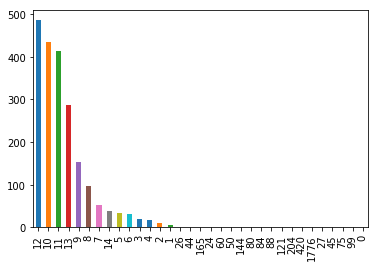

In [205]:
df_outer.rating_numerator.value_counts().plot(kind="bar");


### 2. How does the retweet count compare with the favourite count?

Here, we see medium-coorelation between the number of retweet and the number of favourites. Thus, we can deduce that if a photo has more retweet it is highly likely to have greater number of people who have marked it as favourites.

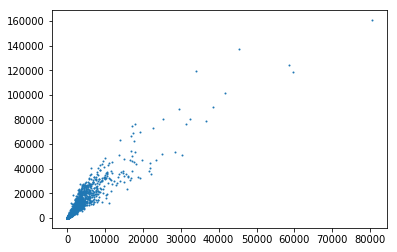

In [206]:
plt.plot(df_outer.tweet_retweet_count, df_outer.tweet_fav_count, 
         linestyle='', marker='o', markersize=1);

### 3. Has the social media engagement of the account grown over time?

From the graph we can clearly see that the twitter account in question has grown consistently through the years. 

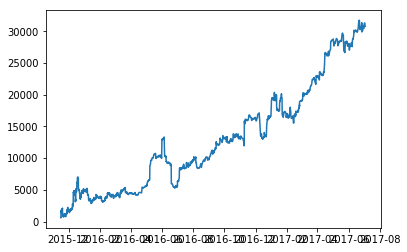

In [207]:
df_outer['avg_fav_count']=df_outer.tweet_fav_count.rolling(window=50).mean()
plt.plot(df_outer.timestamp,df_outer.avg_fav_count,);

### 4. How are the dog breeds distributed?

Thus, we can conclude that the most common dog breed is Golden Retriever.

In [208]:
df_outer.p1.value_counts().head(7)


Golden Retriever      137
Labrador Retriever     94
Pembroke               88
Chihuahua              78
Pug                    54
Chow                   41
Samoyed                40
Name: p1, dtype: int64

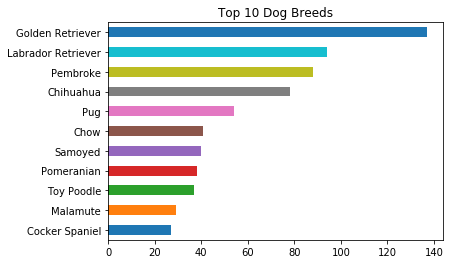

In [209]:
df_outer.p1.value_counts()[10::-1].plot(kind='barh')
plt.title('Top 10 Dog Breeds')
plt.show()

### Conclusion
Thus we conclude from all of the data that - people love Golden Retrievers! And all dogs in general. We also understand that consistent posting on twitter will lead to bigger followings overtime